In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.feature_selection import mutual_info_regression


from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

# Финальный проект DS_32 (Промышленность)
Студент: Тухланов Ярослав 

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Данные

[final_steel.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/f3fbea3a-263d-4e1c-babd-0bf07920c911/final_steel.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_steel/`.

## Исследовательский анализ данных 

### данные об электродах

In [100]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [101]:
print('Количество уникальных значений номера партии:')
len(data_arc['key'].unique())

Количество уникальных значений номера партии:


3214

In [102]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков в data_arc нет. Формат данных приемлемый.

In [103]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc.describe(datetime_is_numeric=True)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-02 16:15:28.218203904,2019-07-02 16:18:19.889150208,0.670441,0.452592
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.030002,-715.504924
25%,806.000000,2019-06-02 07:01:09.249999872,2019-06-02 07:04:21,0.395297,0.290991
50%,1617.000000,2019-06-30 09:57:14.500000,2019-06-30 10:01:01,0.555517,0.415962
75%,2429.000000,2019-08-03 13:04:47.750000128,2019-08-03 13:09:14,0.857034,0.637371
max,3241.000000,2019-09-01 04:34:47,2019-09-01 04:36:08,3.731596,2.676388
std,934.571502,NaN,NaN,0.408159,5.878702


Значения всех признаков соответствуют ожидаемому диапазону, кроме отрицательного значения "Реактивная мощность", определим количество таких (отрицательных) значений данного признака:

In [104]:
print('Индексы строк с отрицательным значением признака "Реактивная мощность":',
      list(data_arc[data_arc['Реактивная мощность'] < 0].index))
print('Количество строк с отрицательным значением признака "Реактивная мощность":',
      (data_arc['Реактивная мощность'] < 0).sum())

Индексы строк с отрицательным значением признака "Реактивная мощность": [9780]
Количество строк с отрицательным значением признака "Реактивная мощность": 1


In [106]:
print('Таблица корреляции признаков data_arc без стрроки 9780:')
data_arc.drop(index=9780).corr()

Таблица корреляции признаков data_arc без стрроки 9780:


,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021367,-0.000159
Активная мощность,-0.021367,1.000000,0.963182
Реактивная мощность,-0.000159,0.963182,1.000000


In [107]:
print('Строки data_arc со схожим (+/- 0.1%) значением "Активная мощность"')
data_arc.drop(index=9780)\
[(data_arc.drop(index=9780)['Активная мощность']\
  < data_arc.loc[9780]['Активная мощность']*1.001) &\
 (data_arc.drop(index=9780)['Активная мощность']\
  > data_arc.loc[9780]['Активная мощность']*0.999)]

Строки data_arc со схожим (+/- 0.1%) значением "Активная мощность"


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
238,51,2019-05-05 05:45:24,2019-05-05 05:47:41,0.495662,0.343805
292,63,2019-05-05 15:48:27,2019-05-05 15:50:53,0.496026,0.442082
1742,375,2019-05-17 13:26:06,2019-05-17 13:27:57,0.495823,0.300950
2892,630,2019-05-26 14:57:15,2019-05-26 14:59:11,0.495938,0.339681
4103,881,2019-06-05 00:20:34,2019-06-05 00:22:41,0.496138,0.396164
4265,916,2019-06-06 02:39:58,2019-06-06 02:42:05,0.495671,0.408666
4354,935,2019-06-07 00:47:14,2019-06-07 00:51:02,0.495849,0.393928
4807,1039,2019-06-10 10:45:15,2019-06-10 10:47:24,0.496053,0.380603
5727,1246,2019-06-17 10:03:32,2019-06-17 10:05:59,0.495823,0.320860
6322,1375,2019-06-22 01:04:15,2019-06-22 01:06:14,0.495692,0.351515


Отрицательное значение признака "Реактивная мощность" встречается всего один раз, явный выброс. Далее это значение следует изменить на среднее значение признака "Реактивная мощность" строк схожих (+/- 0.1%) по признаку "Активная мощность" ввиду присутствия явной корреляции между данными признаками.

In [108]:
data_arc['Реактивная мощность'][data_arc['Реактивная мощность'] > 0].describe()

count    14875.000000
mean         0.500723
std          0.310880
min          0.020806
25%          0.291003
50%          0.415984
75%          0.637403
max          2.676388
Name: Реактивная мощность, dtype: float64

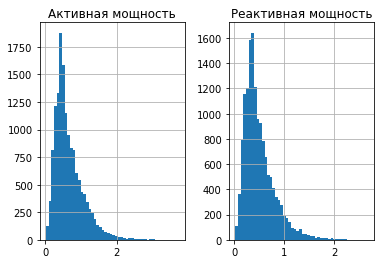

In [109]:
data_arc[['Активная мощность', 'Реактивная мощность']]\
[data_arc['Реактивная мощность'] > 0].hist(bins=50)
plt.show()

Распределения признаков нормальные, данные data_arc можно считать корректными (за исключением строки с индексом 9780).

### данные о подаче сыпучих материалов

#### данные о подаче сыпучих материалов (объём)

In [110]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [111]:
print('Количество уникальных значений номера партии:')
len(data_bulk['key'].unique())

Количество уникальных значений номера партии:


3129

In [112]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Все значения признаков представленны в типе float64, бОльшая часть - пропуски.

In [113]:
data_bulk.min()

key          1.0
Bulk 1      10.0
Bulk 2     228.0
Bulk 3       6.0
Bulk 4      12.0
Bulk 5      11.0
Bulk 6      17.0
Bulk 7      47.0
Bulk 8      49.0
Bulk 9      63.0
Bulk 10     24.0
Bulk 11      8.0
Bulk 12     53.0
Bulk 13    151.0
Bulk 14     16.0
Bulk 15      1.0
dtype: float64

Отрицательных значений нет (выбросов по этому критерию нет).

#### данные о подаче сыпучих материалов (время)

In [114]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [115]:
print('Количество уникальных значений номера партии:')
len(data_bulk_time['key'].unique())

Количество уникальных значений номера партии:


3129

In [116]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Все значения признаков представленны в типе object, бОльшая часть - пропуски. Количества пропусков в признаках data_bulk_time полностью совпадают с колличествами пропусков в признаках data_bulk.

In [117]:
print('Минимальные и максимальные значения data_bulk_time:')
print()
for column in data_bulk_time.drop('key', axis=1).columns:
    print(column+':', pd.to_datetime(data_bulk_time[column]).min(),\
         '-'*5,\
         pd.to_datetime(data_bulk_time[column]).max())

Минимальные и максимальные значения data_bulk_time:

Bulk 1: 2019-05-03 17:50:19 ----- 2019-08-30 23:01:32
Bulk 2: 2019-05-07 08:36:19 ----- 2019-08-08 17:34:38
Bulk 3: 2019-05-03 20:13:36 ----- 2019-08-31 23:39:11
Bulk 4: 2019-05-03 11:21:30 ----- 2019-08-30 17:36:30
Bulk 5: 2019-05-07 08:36:19 ----- 2019-08-28 09:01:08
Bulk 6: 2019-05-03 18:52:57 ----- 2019-09-01 03:12:40
Bulk 7: 2019-05-07 11:37:42 ----- 2019-08-31 07:22:25
Bulk 8: 2019-07-05 17:46:11 ----- 2019-07-05 17:46:11
Bulk 9: 2019-05-14 00:04:56 ----- 2019-08-11 15:09:33
Bulk 10: 2019-05-06 01:36:24 ----- 2019-08-30 01:30:42
Bulk 11: 2019-05-05 16:45:05 ----- 2019-08-31 16:00:49
Bulk 12: 2019-05-03 11:03:52 ----- 2019-09-01 01:39:41
Bulk 13: 2019-05-05 00:39:35 ----- 2019-08-26 20:31:16
Bulk 14: 2019-05-03 11:03:52 ----- 2019-09-01 04:05:34
Bulk 15: 2019-05-03 11:03:52 ----- 2019-09-01 04:05:34


Временные диапазоны data_bulk_time без явных выбросов. 

Разумно предположить, что пропуски в таблице data_bulk означают отсутствие добавок из соответствующего бункера в данной партии key, так же как и пропуски в data_bulk_time. В таком случае если позиции значений без пропусков data_bulk полностью совпадают с позициями значений без пропусков data_bulk_time данные из обеих таблиц можно принять как верные и пригодные для дальнейшего использования.

In [118]:
for column in data_bulk_time.drop('key', axis=1).columns:
    print(column+':')
    if (data_bulk_time[column].isna() & data_bulk[column].isna()).sum() ==\
    (data_bulk_time[column].isna().sum()):
        print('Позиции значений без пропусков полностью совпадают.')
    else:
        print('Ошибка!')

Bulk 1:
Позиции значений без пропусков полностью совпадают.
Bulk 2:
Позиции значений без пропусков полностью совпадают.
Bulk 3:
Позиции значений без пропусков полностью совпадают.
Bulk 4:
Позиции значений без пропусков полностью совпадают.
Bulk 5:
Позиции значений без пропусков полностью совпадают.
Bulk 6:
Позиции значений без пропусков полностью совпадают.
Bulk 7:
Позиции значений без пропусков полностью совпадают.
Bulk 8:
Позиции значений без пропусков полностью совпадают.
Bulk 9:
Позиции значений без пропусков полностью совпадают.
Bulk 10:
Позиции значений без пропусков полностью совпадают.
Bulk 11:
Позиции значений без пропусков полностью совпадают.
Bulk 12:
Позиции значений без пропусков полностью совпадают.
Bulk 13:
Позиции значений без пропусков полностью совпадают.
Bulk 14:
Позиции значений без пропусков полностью совпадают.
Bulk 15:
Позиции значений без пропусков полностью совпадают.


Значения таблиц data_bulk и data_bulk_time пригодны для дальнекйшего использования.

### данные о проволочных материалах

#### данные о проволочных материалах (объём)

In [119]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
print('Количество уникальных значений номера партии:')
len(data_wire['key'].unique())

Количество уникальных значений номера партии:


3081

In [121]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Все значения признаков в data_wire представлены в типе float64. Wire 1 почти без пропусков, Wire 2 - около трети без пропусков, остальные значения почти отсутствуют.

In [122]:
data_wire.min()

key        1.000000
Wire 1     1.918800
Wire 2     0.030160
Wire 3     0.144144
Wire 4    24.148801
Wire 5    15.132000
Wire 6     0.034320
Wire 7     0.234208
Wire 8    45.076721
Wire 9     4.622800
dtype: float64

Отрицательных значений нет (выбросов по этому критерию нет).

####  данные о проволочных материалах (время)

In [123]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
print('Количество уникальных значений номера партии:')
len(data_wire_time['key'].unique())

Количество уникальных значений номера партии:


3081

In [125]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Все значения признаков в data_wire_time представлены в типе object. Wire 1 почти без пропусков, Wire 2 - около трети без пропусков, остальные значения почти отсутствуют. Количества пропусков в признаках data_wire_time полностью совпадают с количествами пропусков в признаках data_wire.

In [126]:
print('Минимальные и максимальные значения data_wire_time:')
print()
for column in data_wire_time.drop('key', axis=1).columns:
    print(column+':', pd.to_datetime(data_wire_time[column]).min(),\
         '-'*5,\
         pd.to_datetime(data_wire_time[column]).max())

Минимальные и максимальные значения data_wire_time:

Wire 1: 2019-05-03 11:11:41 ----- 2019-09-01 04:16:01
Wire 2: 2019-05-03 13:32:06 ----- 2019-08-31 18:50:15
Wire 3: 2019-05-04 04:47:53 ----- 2019-08-28 02:11:18
Wire 4: 2019-05-07 08:48:23 ----- 2019-08-08 12:03:12
Wire 5: 2019-08-08 16:01:07 ----- 2019-08-08 16:01:07
Wire 6: 2019-05-07 08:37:20 ----- 2019-08-14 00:59:11
Wire 7: 2019-07-23 12:08:44 ----- 2019-08-08 18:27:34
Wire 8: 2019-05-14 00:03:32 ----- 2019-08-11 15:09:29
Wire 9: 2019-05-04 16:09:11 ----- 2019-08-29 03:51:31


Временные диапазоны data_wire_time без явных выбросов.

По аналогии с data_bulk и data_bulk_time разумно предположить, что пропуски в таблице data_wire означают отсутствие добавок соответствующего провода в данной партии key, так же как и пропуски в data_wire_time. В таком случае если позиции значений без пропусков data_wire полностью совпадают с позициями значений без пропусков data_wire_time данные из обеих таблиц можно принять как верные и пригодные для дальнейшего использования.

In [127]:
for column in data_wire.drop('key', axis=1).columns:
    print(column+':')
    if (data_wire[column].isna() & data_wire_time[column].isna()).sum() ==\
    (data_wire[column].isna().sum()):
        print('Позиции значений без пропусков полностью совпадают.')
    else:
        print('Ошибка!')

Wire 1:
Позиции значений без пропусков полностью совпадают.
Wire 2:
Позиции значений без пропусков полностью совпадают.
Wire 3:
Позиции значений без пропусков полностью совпадают.
Wire 4:
Позиции значений без пропусков полностью совпадают.
Wire 5:
Позиции значений без пропусков полностью совпадают.
Wire 6:
Позиции значений без пропусков полностью совпадают.
Wire 7:
Позиции значений без пропусков полностью совпадают.
Wire 8:
Позиции значений без пропусков полностью совпадают.
Wire 9:
Позиции значений без пропусков полностью совпадают.


Значения таблиц data_wire и data_wire_time пригодны для дальнекйшего использования.

### данные о продувке сплава газом

In [128]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [129]:
print('Количество уникальных значений номера партии:')
len(data_gas['key'].unique())

Количество уникальных значений номера партии:


3239

In [130]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет, тип данных - float64. 

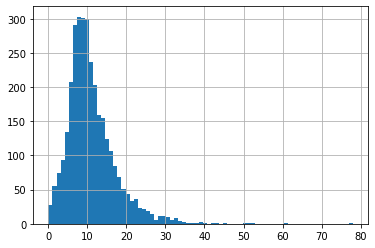

In [131]:
data_gas['Газ 1'].hist(bins=75)
plt.show()

Распределение признаков нормальное. Данные data_gas можно считать пригодными для дальнейшей работы.

### результаты измерения температуры

In [132]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [133]:
print('Количество уникальных значений номера партии:')
len(data_temp['key'].unique())

Количество уникальных значений номера партии:


3216

In [134]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


2901 строка с пропусками значений "Температура", это почти 20% от всеё таблицы. В случае использовании данных data_temp пропуски необходимо заполнить, или придётся избавиться от этих строк.

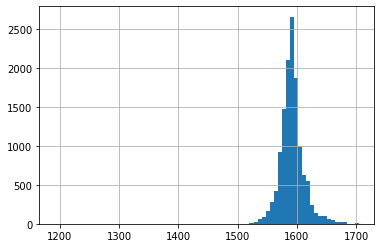

In [135]:
data_temp['Температура'].hist(bins=75)
plt.show()

Распределение нормальное, однако есть подозрение на выбросы в значениях менее 1500.

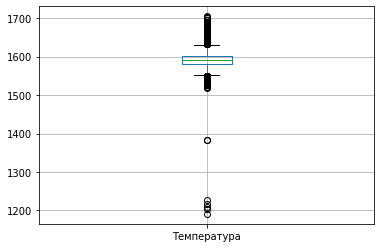

In [136]:
data_temp.boxplot(column='Температура')
plt.show()

Значения признака "Температура" менее 1500 можно признать выбросами.

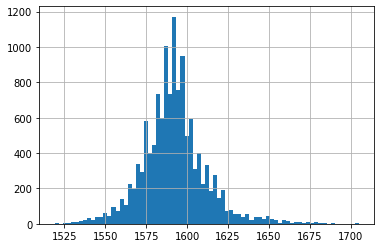

In [137]:
data_temp['Температура'][data_temp['Температура'] > 1500].hist(bins=75)
plt.show()

График гистограммы имеет нормальное распределение, однако видны всплески примерно через каждые пять едениц. Это можно связать с особенностями технологического процесса.

### вывод

Данные имеют некоторую погрешность: пропуски в знапчениях data_temp['Температура'] наиболее маштабны. Кроме того: количества уникальных значений номера партии в разных таблицах разняться, что так же может отразиться на количестве используемых данных.

## Уточняющие вопросы

Самый главный вопрос для меня на данный момент это определение целевого признака: требуется модель предсказывающая температуру стали на каком этапе? В каждой партии происходит разное количество итераций: необходимо предсказать температуру для каждой, или среднюю для партии?

Ответ:

Целевым признаком является значение температуры сплава каждой партиии после всех итераций.

## План решения

1. Заполнение/исключение пропусков (выбрасов).
2. Объединение таблиц.
3. Определение необходимых для обучения модедели признаков.
4. Проверка признаков на мультиколлинеарность.
5. Обучение и валидация разных моделей.
6. Анализ важности факторов у модели-победителя.
7. Тестирование модели-победителя на наборе отобранных признаков.

## Предобработка данных

### Заполнение/исключение пропусков (выбрасов)

#### данные об электродах

Заменим значение data_arc.loc[9780, 'Реактивная мощность'] на среднее значение признака "Реактивная мощность" строк схожих (+/- 0.1%) по признаку "Активная мощность".

In [138]:
data_arc.loc[9780, 'Реактивная мощность'] =\
data_arc.drop(index=9780)\
[(data_arc.drop(index=9780)['Активная мощность']\
  < data_arc.loc[9780]['Активная мощность']*1.001) &\
 (data_arc.drop(index=9780)['Активная мощность']\
  > data_arc.loc[9780]['Активная мощность']*0.999)]['Реактивная мощность'].mean()

print('data_arc.loc[9780]["Реактивная мощность"] =',
data_arc.loc[9780, 'Реактивная мощность'])

data_arc.loc[9780]["Реактивная мощность"] = 0.387059614


In [139]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


#### данные о подаче сыпучих материалов (объём)

Исходя из исследовательского анализа данных заменим пропуски в data_bulk на 0.

In [140]:
data_bulk = data_bulk.fillna(0)
display(data_bulk.head(10))
data_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
5,6,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0
6,7,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0
7,8,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0
8,9,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


#### данные о проволочных материалах

Исходя из исследовательского анализа данных заменим пропуски в data_wire на 0.

In [141]:
data_wire = data_wire.fillna(0)
display(data_wire.head(10))
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


#### результаты измерения температуры

Избавимся от выбросов на основании исследовательского анализа.

In [142]:
data_temp = data_temp[~(data_temp['Температура'] < 1500)]

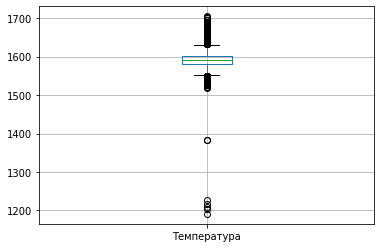

In [143]:
pd.read_csv('/datasets/final_steel/data_temp.csv').boxplot(column='Температура')
plt.show()

Целевым признаком определено значение температуры сплава для каждой партии key определённое после всех этапов обработки. Для выделения целевого признака оставим в data_temp только максимальные значения времени замера температуры, приведённые к типу datetime, для каждой партии key .  А так же добавим в таблицу разницу между первым и последним замером температуры.

In [144]:
initial_temp = \
data_temp[data_temp['Время замера'] == 
          data_temp.groupby('key')['Время замера'].transform('min')]

initial_temp = \
initial_temp.rename(columns={"Температура": "initial_temp"}).reset_index(drop=True)

initial_temp.head(10)

,key,Время замера,initial_temp
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
5,6,2019-05-03 13:49:24,1543.0
6,7,2019-05-03 14:19:43,1586.0
7,8,2019-05-03 15:07:18,1577.0
8,9,2019-05-03 15:37:03,1587.0
9,10,2019-05-03 16:14:29,1574.0


In [145]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
last_iteration = data_temp.groupby('key').max()['Время замера']
last_iteration.head(10)

key
1    2019-05-03 11:30:39
2    2019-05-03 11:59:12
3    2019-05-03 12:34:57
4    2019-05-03 12:59:25
5    2019-05-03 13:36:01
6    2019-05-03 14:12:29
7    2019-05-03 14:42:37
8    2019-05-03 15:22:52
9    2019-05-03 16:01:16
10   2019-05-03 16:36:08
Name: Время замера, dtype: datetime64[ns]

In [146]:
all_time = \
data_temp.groupby('key').agg(
    {'Время замера': ('min', 'max')}
).reset_index()

In [147]:
all_time

key        Время замера                    
                           min                 max
0        1 2019-05-03 11:16:18 2019-05-03 11:30:39
1        2 2019-05-03 11:37:27 2019-05-03 11:59:12
2        3 2019-05-03 12:13:17 2019-05-03 12:34:57
3        4 2019-05-03 12:52:57 2019-05-03 12:59:25
4        5 2019-05-03 13:23:19 2019-05-03 13:36:01
...    ...                 ...                 ...
3211  3237 2019-08-31 22:44:04 2019-08-31 23:05:43
3212  3238 2019-08-31 23:30:31 2019-08-31 23:43:00
3213  3239 2019-09-01 01:31:47 2019-09-01 02:24:15
3214  3240 2019-09-01 02:39:01 2019-09-01 03:35:16
3215  3241 2019-09-01 04:03:30 2019-09-01 04:38:08

[3216 rows x 3 columns]

In [148]:
all_time['all_time'] = \
pd.to_numeric(all_time['Время замера']['max'] - all_time['Время замера']['min'])

In [149]:
data_temp = data_temp[data_temp['Время замера'].isin(last_iteration)]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 4 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3216 non-null   int64         
 1   Время замера  3216 non-null   datetime64[ns]
 2   Температура   2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 100.5 KB


Из 3216 партий только 2477 не имеют пропусков в значении целевого признака "Температура". Заполнение данных пропусков какими-либо усреднёнными значениями признаем не приемлемым из-за возможного искаженния результатов исследования. Оставим только строки без пропусков в целевом признаке.

In [150]:
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 4 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           2477 non-null   int64         
 1   Время замера  2477 non-null   datetime64[ns]
 2   Температура   2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 77.4 KB


In [151]:
data_temp = \
data_temp.merge(
    initial_temp[['key', 'initial_temp']],
    on='key',
    how='left')

In [152]:
data_temp = \
data_temp.merge(
    all_time[['key', 'all_time']],
    on='key',
    how='left')

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


In [153]:
data_temp['all_time'] = data_temp.iloc[:, 4]
data_temp = data_temp[['key', 'Время замера', 'Температура', 'all_time', 'initial_temp']]
display(data_temp.info())
data_temp.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           2477 non-null   int64         
 1   Время замера  2477 non-null   datetime64[ns]
 2   Температура   2477 non-null   float64       
 3   all_time      2477 non-null   int64         
 4   initial_temp  2477 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 116.1 KB


None

,key,Время замера,Температура,all_time,initial_temp
0,1,2019-05-03 11:30:39,1613.0,861000000000,1571.0
1,2,2019-05-03 11:59:12,1602.0,1305000000000,1581.0
2,3,2019-05-03 12:34:57,1599.0,1300000000000,1596.0
3,4,2019-05-03 12:59:25,1625.0,388000000000,1601.0
4,5,2019-05-03 13:36:01,1602.0,762000000000,1576.0
5,6,2019-05-03 14:12:29,1596.0,1385000000000,1543.0
6,7,2019-05-03 14:42:37,1599.0,1374000000000,1586.0
7,8,2019-05-03 15:22:52,1598.0,934000000000,1577.0
8,9,2019-05-03 16:01:16,1592.0,1453000000000,1587.0
9,10,2019-05-03 16:36:08,1593.0,1299000000000,1574.0


### Объединение таблиц / Определение необходимых для обучения модедели признаков

 #### данные об электродах

Создадим признаки для каждой партии key:

* суммарного нагрева электродами 
* среднего значения соотношения потребления активной и реактивной мощности
* количества запусков нагрева электродами

In [154]:
data_arc['Время нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['Время нагрева'] = pd.to_numeric(data_arc['Время нагрева'])

data_arc['ratio'] = data_arc['Активная мощность'] / data_arc['Реактивная мощность']

data_arc = \
data_arc.groupby('key').agg(
    {'Время нагрева': 'sum',
     'ratio': 'mean',
     'Начало нагрева дугой': 'count',
     'Конец нагрева дугой': 'max'
    }).reset_index()

In [155]:
display(data_arc.head(10))
data_arc.info()

,key,Время нагрева,ratio,Начало нагрева дугой,Конец нагрева дугой
0,1,1098000000000,1.538898,5,2019-05-03 11:28:37
1,2,811000000000,1.551834,4,2019-05-03 11:53:18
2,3,655000000000,1.583120,5,2019-05-03 12:32:19
3,4,741000000000,1.563487,4,2019-05-03 12:57:50
4,5,869000000000,1.480428,4,2019-05-03 13:33:55
5,6,952000000000,1.501854,4,2019-05-03 14:09:24
6,7,673000000000,1.628748,4,2019-05-03 14:41:15
7,8,913000000000,1.486391,4,2019-05-03 15:14:47
8,9,625000000000,1.421598,5,2019-05-03 15:59:48
9,10,825000000000,1.231654,6,2019-05-03 16:34:50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   3214 non-null   int64         
 1   Время нагрева         3214 non-null   int64         
 2   ratio                 3214 non-null   float64       
 3   Начало нагрева дугой  3214 non-null   int64         
 4   Конец нагрева дугой   3214 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 125.7 KB


Создадим таблицу df из data_arc и data_temp, исключим строки с пропусками.

In [156]:
df = (
    data_temp.merge(
    data_arc,
    on='key',
    how='left')
    ).dropna()

In [157]:
display(df.head(10))
df.info()

,key,Время замера,Температура,all_time,initial_temp,Время нагрева,ratio,Начало нагрева дугой,Конец нагрева дугой
0,1,2019-05-03 11:30:39,1613.0,861000000000,1571.0,1.098000e+12,1.538898,5.0,2019-05-03 11:28:37
1,2,2019-05-03 11:59:12,1602.0,1305000000000,1581.0,8.110000e+11,1.551834,4.0,2019-05-03 11:53:18
2,3,2019-05-03 12:34:57,1599.0,1300000000000,1596.0,6.550000e+11,1.583120,5.0,2019-05-03 12:32:19
3,4,2019-05-03 12:59:25,1625.0,388000000000,1601.0,7.410000e+11,1.563487,4.0,2019-05-03 12:57:50
4,5,2019-05-03 13:36:01,1602.0,762000000000,1576.0,8.690000e+11,1.480428,4.0,2019-05-03 13:33:55
5,6,2019-05-03 14:12:29,1596.0,1385000000000,1543.0,9.520000e+11,1.501854,4.0,2019-05-03 14:09:24
6,7,2019-05-03 14:42:37,1599.0,1374000000000,1586.0,6.730000e+11,1.628748,4.0,2019-05-03 14:41:15
7,8,2019-05-03 15:22:52,1598.0,934000000000,1577.0,9.130000e+11,1.486391,4.0,2019-05-03 15:14:47
8,9,2019-05-03 16:01:16,1592.0,1453000000000,1587.0,6.250000e+11,1.421598,5.0,2019-05-03 15:59:48
9,10,2019-05-03 16:36:08,1593.0,1299000000000,1574.0,8.250000e+11,1.231654,6.0,2019-05-03 16:34:50


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   2475 non-null   int64         
 1   Время замера          2475 non-null   datetime64[ns]
 2   Температура           2475 non-null   float64       
 3   all_time              2475 non-null   int64         
 4   initial_temp          2475 non-null   float64       
 5   Время нагрева         2475 non-null   float64       
 6   ratio                 2475 non-null   float64       
 7   Начало нагрева дугой  2475 non-null   float64       
 8   Конец нагрева дугой   2475 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 193.4 KB


Партии key, где финальный замер температуры был произведён до финальной итерации, являютя не пригодными для дольнейшей работы, поскольку значение признака Температура не является целевым по определению. Исключим данные партии.

In [158]:
df =\
df[df['Время замера'] > df['Конец нагрева дугой']]\
.drop('Конец нагрева дугой', axis=1)

In [159]:
display(df.head(10))
df.info()

,key,Время замера,Температура,all_time,initial_temp,Время нагрева,ratio,Начало нагрева дугой
0,1,2019-05-03 11:30:39,1613.0,861000000000,1571.0,1.098000e+12,1.538898,5.0
1,2,2019-05-03 11:59:12,1602.0,1305000000000,1581.0,8.110000e+11,1.551834,4.0
2,3,2019-05-03 12:34:57,1599.0,1300000000000,1596.0,6.550000e+11,1.583120,5.0
3,4,2019-05-03 12:59:25,1625.0,388000000000,1601.0,7.410000e+11,1.563487,4.0
4,5,2019-05-03 13:36:01,1602.0,762000000000,1576.0,8.690000e+11,1.480428,4.0
5,6,2019-05-03 14:12:29,1596.0,1385000000000,1543.0,9.520000e+11,1.501854,4.0
6,7,2019-05-03 14:42:37,1599.0,1374000000000,1586.0,6.730000e+11,1.628748,4.0
7,8,2019-05-03 15:22:52,1598.0,934000000000,1577.0,9.130000e+11,1.486391,4.0
8,9,2019-05-03 16:01:16,1592.0,1453000000000,1587.0,6.250000e+11,1.421598,5.0
9,10,2019-05-03 16:36:08,1593.0,1299000000000,1574.0,8.250000e+11,1.231654,6.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2476
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   2344 non-null   int64         
 1   Время замера          2344 non-null   datetime64[ns]
 2   Температура           2344 non-null   float64       
 3   all_time              2344 non-null   int64         
 4   initial_temp          2344 non-null   float64       
 5   Время нагрева         2344 non-null   float64       
 6   ratio                 2344 non-null   float64       
 7   Начало нагрева дугой  2344 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 164.8 KB


#### данные о подаче сыпучих материалов

Добавление разных сыпучих материалов в разных объёмах могут по разному отражаться на температуре сплава.

Добавим к df данные data_bulk_time приведённые к типу datetime. Затем исключим строки в которых последний замер температуры был выполнен раньше последнего добаления сыпучих материалов и исключим из df признаки data_bulk_time за ненадобностью дальнейшего их использования.

In [160]:
for column in data_bulk_time.columns.drop('key'):
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column])

In [161]:
df = df.merge(
    data_bulk_time,
    on='key',
    how='left')

In [162]:
for num_col in range(-len(data_bulk_time.columns.drop('key')), 0):
    df = df[~(df.loc[:, 'Время замера'] < df.iloc[:, num_col])]

In [163]:
df = df.iloc[:, : -len(data_bulk_time.columns.drop('key'))]

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2343
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   2340 non-null   int64         
 1   Время замера          2340 non-null   datetime64[ns]
 2   Температура           2340 non-null   float64       
 3   all_time              2340 non-null   int64         
 4   initial_temp          2340 non-null   float64       
 5   Время нагрева         2340 non-null   float64       
 6   ratio                 2340 non-null   float64       
 7   Начало нагрева дугой  2340 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 164.5 KB


Добавим к df данные data_bulk и исключим пропуски.

In [165]:
df = df.merge(
    data_bulk,
    on='key',
    how='left').dropna()

In [166]:
display(df.head(10))
df.info()

,key,Время замера,Температура,all_time,initial_temp,Время нагрева,ratio,Начало нагрева дугой,Bulk 1,Bulk 2,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:30:39,1613.0,861000000000,1571.0,1.098000e+12,1.538898,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:59:12,1602.0,1305000000000,1581.0,8.110000e+11,1.551834,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:34:57,1599.0,1300000000000,1596.0,6.550000e+11,1.583120,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:59:25,1625.0,388000000000,1601.0,7.410000e+11,1.563487,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:36:01,1602.0,762000000000,1576.0,8.690000e+11,1.480428,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
5,6,2019-05-03 14:12:29,1596.0,1385000000000,1543.0,9.520000e+11,1.501854,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0
6,7,2019-05-03 14:42:37,1599.0,1374000000000,1586.0,6.730000e+11,1.628748,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0
7,8,2019-05-03 15:22:52,1598.0,934000000000,1577.0,9.130000e+11,1.486391,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0
8,9,2019-05-03 16:01:16,1592.0,1453000000000,1587.0,6.250000e+11,1.421598,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0
9,10,2019-05-03 16:36:08,1593.0,1299000000000,1574.0,8.250000e+11,1.231654,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2279 entries, 0 to 2339
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   2279 non-null   int64         
 1   Время замера          2279 non-null   datetime64[ns]
 2   Температура           2279 non-null   float64       
 3   all_time              2279 non-null   int64         
 4   initial_temp          2279 non-null   float64       
 5   Время нагрева         2279 non-null   float64       
 6   ratio                 2279 non-null   float64       
 7   Начало нагрева дугой  2279 non-null   float64       
 8   Bulk 1                2279 non-null   float64       
 9   Bulk 2                2279 non-null   float64       
 10  Bulk 3                2279 non-null   float64       
 11  Bulk 4                2279 non-null   float64       
 12  Bulk 5                2279 non-null   float64       
 13  Bulk 6            

#### данные о проволочных материалах

Добавление разных проволочных материалов в разных объёмах могут по разному отражаться на температуре сплава.

Добавим к df данные data_wire_time приведённые к типу datetime. Затем исключим строки в которых последний замер температуры был выполнен раньше последнего добаления проволочных материалов и исключим из df признаки data_wire_time за ненадобностью дальнейшего их использования.

In [167]:
for column in data_wire_time.columns.drop('key'):
    data_wire_time[column] = pd.to_datetime(data_wire_time[column])

In [168]:
df = df.merge(
    data_wire_time,
    on='key',
    how='left')

In [169]:
for num_col in range(-len(data_wire_time.columns.drop('key')), 0):
    df = df[~(df.loc[:, 'Время замера'] < df.iloc[:, num_col])]

In [170]:
df = df.iloc[:, : -len(data_wire_time.columns.drop('key'))]

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2279 entries, 0 to 2278
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   2279 non-null   int64         
 1   Время замера          2279 non-null   datetime64[ns]
 2   Температура           2279 non-null   float64       
 3   all_time              2279 non-null   int64         
 4   initial_temp          2279 non-null   float64       
 5   Время нагрева         2279 non-null   float64       
 6   ratio                 2279 non-null   float64       
 7   Начало нагрева дугой  2279 non-null   float64       
 8   Bulk 1                2279 non-null   float64       
 9   Bulk 2                2279 non-null   float64       
 10  Bulk 3                2279 non-null   float64       
 11  Bulk 4                2279 non-null   float64       
 12  Bulk 5                2279 non-null   float64       
 13  Bulk 6            

Добавим к df данные data_wire и исключим пропуски.

In [172]:
df = df.merge(
    data_wire,
    on='key',
    how='left').dropna()

In [173]:
display(df.head(10))
df.info()

,key,Время замера,Температура,all_time,initial_temp,Время нагрева,ratio,Начало нагрева дугой,Bulk 1,Bulk 2,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:30:39,1613.0,861000000000,1571.0,1.098000e+12,1.538898,5.0,0.0,0.0,...,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:59:12,1602.0,1305000000000,1581.0,8.110000e+11,1.551834,4.0,0.0,0.0,...,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:34:57,1599.0,1300000000000,1596.0,6.550000e+11,1.583120,5.0,0.0,0.0,...,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:59:25,1625.0,388000000000,1601.0,7.410000e+11,1.563487,4.0,0.0,0.0,...,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:36:01,1602.0,762000000000,1576.0,8.690000e+11,1.480428,4.0,0.0,0.0,...,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,2019-05-03 14:12:29,1596.0,1385000000000,1543.0,9.520000e+11,1.501854,4.0,0.0,0.0,...,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,2019-05-03 14:42:37,1599.0,1374000000000,1586.0,6.730000e+11,1.628748,4.0,0.0,0.0,...,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,2019-05-03 15:22:52,1598.0,934000000000,1577.0,9.130000e+11,1.486391,4.0,0.0,0.0,...,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,2019-05-03 16:01:16,1592.0,1453000000000,1587.0,6.250000e+11,1.421598,5.0,0.0,0.0,...,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,2019-05-03 16:36:08,1593.0,1299000000000,1574.0,8.250000e+11,1.231654,6.0,0.0,0.0,...,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 0 to 2278
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   2208 non-null   int64         
 1   Время замера          2208 non-null   datetime64[ns]
 2   Температура           2208 non-null   float64       
 3   all_time              2208 non-null   int64         
 4   initial_temp          2208 non-null   float64       
 5   Время нагрева         2208 non-null   float64       
 6   ratio                 2208 non-null   float64       
 7   Начало нагрева дугой  2208 non-null   float64       
 8   Bulk 1                2208 non-null   float64       
 9   Bulk 2                2208 non-null   float64       
 10  Bulk 3                2208 non-null   float64       
 11  Bulk 4                2208 non-null   float64       
 12  Bulk 5                2208 non-null   float64       
 13  Bulk 6            

Исключим из df признаки не связанные с посттроением модели: key, Время замера.

In [174]:
df = df.drop(['key', 'Время замера'], axis=1)

Все данные признанные необходимыми для создания модели собраны в одну таблицу df.

In [175]:
df.head()

,Температура,all_time,initial_temp,Время нагрева,ratio,Начало нагрева дугой,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1613.0,861000000000,1571.0,1.098000e+12,1.538898,5.0,0.0,0.0,0.0,43.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1602.0,1305000000000,1581.0,8.110000e+11,1.551834,4.0,0.0,0.0,0.0,73.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1599.0,1300000000000,1596.0,6.550000e+11,1.583120,5.0,0.0,0.0,0.0,34.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1625.0,388000000000,1601.0,7.410000e+11,1.563487,4.0,0.0,0.0,0.0,81.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1602.0,762000000000,1576.0,8.690000e+11,1.480428,4.0,0.0,0.0,0.0,78.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Проверка признаков на мультиколлинеарность

In [176]:
df_corr = df.corr()
for col in df_corr.columns:
    if len(
        df_corr[(abs(df_corr[col]) > 0.9) & (df_corr[col] != 1)].index) > 0:
        print(col, df_corr[(abs(df_corr[col]) > 0.9) & (df_corr[col] != 1)].index)

Bulk 9 Index(['Wire 8'], dtype='object')
Wire 8 Index(['Bulk 9'], dtype='object')


Коэффициент корреляции Пирсона показывает взаимосвязь между разными признаками. Выберем признаки с абсолютным значением коэффициента более 0,9:

* Bulk 9, Wire 8

Из признаков с высокой корреляцией оставим только наиболее значимый для определения целевого признака Температура. Оценку значимости выполним так же с помощью коэффициента корреляции Пирсона.

In [177]:
df[['Температура', 'Bulk 9', 'Wire 8']].corr()

,Температура,Bulk 9,Wire 8
Температура,1.000000,-0.017167,-0.011728
Bulk 9,-0.017167,1.000000,0.974962
Wire 8,-0.011728,0.974962,1.000000


In [178]:
df = df.drop('Wire 8', axis=1)

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 0 to 2278
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Температура           2208 non-null   float64
 1   all_time              2208 non-null   int64  
 2   initial_temp          2208 non-null   float64
 3   Время нагрева         2208 non-null   float64
 4   ratio                 2208 non-null   float64
 5   Начало нагрева дугой  2208 non-null   float64
 6   Bulk 1                2208 non-null   float64
 7   Bulk 2                2208 non-null   float64
 8   Bulk 3                2208 non-null   float64
 9   Bulk 4                2208 non-null   float64
 10  Bulk 5                2208 non-null   float64
 11  Bulk 6                2208 non-null   float64
 12  Bulk 7                2208 non-null   float64
 13  Bulk 8                2208 non-null   float64
 14  Bulk 9                2208 non-null   float64
 15  Bulk 10              

Данные готовы для создания модели.

## Обучение и валидация разных моделей

Разделение данных

Разделим данные на обучающую (80%) и тестовую (20%) выборки, а их в свою очередь на выборки с целевым признаком target_train, target_test и остальными признаками features_train, features_test.

In [180]:
features = df.drop('Температура', axis=1)
target = df['Температура']
features.info()
(target).to_frame().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 0 to 2278
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   all_time              2208 non-null   int64  
 1   initial_temp          2208 non-null   float64
 2   Время нагрева         2208 non-null   float64
 3   ratio                 2208 non-null   float64
 4   Начало нагрева дугой  2208 non-null   float64
 5   Bulk 1                2208 non-null   float64
 6   Bulk 2                2208 non-null   float64
 7   Bulk 3                2208 non-null   float64
 8   Bulk 4                2208 non-null   float64
 9   Bulk 5                2208 non-null   float64
 10  Bulk 6                2208 non-null   float64
 11  Bulk 7                2208 non-null   float64
 12  Bulk 8                2208 non-null   float64
 13  Bulk 9                2208 non-null   float64
 14  Bulk 10               2208 non-null   float64
 15  Bulk 11              

In [181]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.2, random_state=9)

In [182]:
print('features_train.shape:', features_train.shape)
print('features_test.shape:', features_test.shape)
print('target_train.shape:', target_train.shape)
print('target_test.shape:', target_test.shape)

features_train.shape: (1766, 28)
features_test.shape: (442, 28)
target_train.shape: (1766,)
target_test.shape: (442,)


### LinearRegression

In [183]:
model = LinearRegression()

In [184]:
pg = {'fit_intercept':['True', 'False']}

In [185]:
GSCV = GridSearchCV(model, param_grid=pg, cv=5, scoring='neg_mean_absolute_error')
GSCV.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': ['True', 'False']},
             scoring='neg_mean_absolute_error')

In [186]:
print('GSCV.best_score_:', abs(GSCV.best_score_))
print('GSCV.best_params_:', GSCV.best_params_)

GSCV.best_score_: 5.902213326210854
GSCV.best_params_: {'fit_intercept': 'True'}


In [187]:
model = LinearRegression(fit_intercept=True)
model.fit(features_train, target_train)
predict_data = model.predict(features_test)
result = round(mean_absolute_error(target_test, predict_data), 2)
print('MAE LinearRegression(fit_intercept=True) на тестовой выборке:',
      result)

MAE LinearRegression(fit_intercept=True) на тестовой выборке: 5.69


### DecisionTreeRegressor

In [188]:
model = DecisionTreeRegressor()

In [189]:
pg = {'max_depth':range(1, 250), 'random_state':[9]}

In [190]:
GSCV = GridSearchCV(model, param_grid=pg, cv=5, scoring='neg_mean_absolute_error')
GSCV.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 250), 'random_state': [9]},
             scoring='neg_mean_absolute_error')

In [191]:
print('GSCV.best_score_:', abs(GSCV.best_score_))
print('GSCV.best_params_:', GSCV.best_params_)

GSCV.best_score_: 7.061661745940333
GSCV.best_params_: {'max_depth': 5, 'random_state': 9}


In [192]:
model = DecisionTreeRegressor(max_depth=5, random_state=9)
model.fit(features_train, target_train)
predict_data = model.predict(features_test)
result = round(mean_absolute_error(target_test, predict_data), 2)
print('MAE DecisionTreeRegressor(max_depth=5, random_state=9) на тестовой выборке:',
      result)

MAE DecisionTreeRegressor(max_depth=5, random_state=9) на тестовой выборке: 6.69


### RandomForestRegressor

In [193]:
model = RandomForestRegressor()

In [194]:
pg = {'max_depth':range(1, 10), 'n_estimators':range(75, 126, 10), 'random_state':[9]}

In [195]:
GSCV = GridSearchCV(model, param_grid=pg, cv=5, scoring='neg_mean_absolute_error')
GSCV.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(75, 126, 10),
                         'random_state': [9]},
             scoring='neg_mean_absolute_error')

In [196]:
print('GSCV.best_score_:', abs(GSCV.best_score_))
print('GSCV.best_params_:', GSCV.best_params_)

GSCV.best_score_: 6.123228155741915
GSCV.best_params_: {'max_depth': 9, 'n_estimators': 75, 'random_state': 9}


In [197]:
model = RandomForestRegressor(max_depth=9,
                              n_estimators=75,
                              random_state=9)
model.fit(features_train, target_train)
predict_data = model.predict(features_test)
result = round(mean_absolute_error(target_test, predict_data), 2)
print('''MAE RandomForestRegressor
(max_depth=9, n_estimators=75, random_state=9)
на тестовой выборке:''',
      result)

MAE RandomForestRegressor
(max_depth=9, n_estimators=75, random_state=9)
на тестовой выборке: 5.74


### CatBoostRegressor

In [198]:
model = CatBoostRegressor()

In [199]:
pg = {'iterations':[50, 52, 48],
      'learning_rate':[.16, .18, .2],
      'depth':[6, 8, 7],
      'loss_function':["MAE"],
      'verbose':[False]}

In [200]:
GSCV = GridSearchCV(model, param_grid=pg, cv=5, scoring='neg_mean_absolute_error')
GSCV.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4ffb5a64c0>,
             param_grid={'depth': [6, 8, 7], 'iterations': [50, 52, 48],
                         'learning_rate': [0.16, 0.18, 0.2],
                         'loss_function': ['MAE'], 'verbose': [False]},
             scoring='neg_mean_absolute_error')

In [201]:
print('GSCV.best_score_:', abs(GSCV.best_score_))
print('GSCV.best_params_:', GSCV.best_params_)

GSCV.best_score_: 5.977343452481999
GSCV.best_params_: {'depth': 7, 'iterations': 52, 'learning_rate': 0.16, 'loss_function': 'MAE', 'verbose': False}


In [202]:
model = CatBoostRegressor(iterations=52,
                          learning_rate=.16,
                          depth=7,
                          loss_function='MAE',
                          verbose=False
                         )
model.fit(features_train, target_train)
predict_data = model.predict(features_test)
result = round(mean_absolute_error(target_test, predict_data), 2)
print('''MAE CatBoostRegressor
(iterations=52, learning_rate=0.16, depth=7, loss_function="MAE", verbose=False)
на тестовой выборке:''',
      result)

MAE CatBoostRegressor
(iterations=52, learning_rate=0.16, depth=7, loss_function="MAE", verbose=False)
на тестовой выборке: 5.66


### LGBMRegressor

In [206]:
model = LGBMRegressor()

In [207]:
pg = {'n_estimators':[200, 190, 250],
      'learning_rate':[.09, .08, .1],
      'max_depth':[8, 7, 6]}

In [208]:
GSCV = GridSearchCV(model, param_grid=pg, cv=5, scoring='neg_mean_absolute_error')
GSCV.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.09, 0.08, 0.1],
                         'max_depth': [8, 7, 6],
                         'n_estimators': [200, 190, 250]},
             scoring='neg_mean_absolute_error')

In [209]:
print('GSCV.best_score_:', abs(GSCV.best_score_))
print('GSCV.best_params_:', GSCV.best_params_)

GSCV.best_score_: 5.801615076462613
GSCV.best_params_: {'learning_rate': 0.08, 'max_depth': 7, 'n_estimators': 190}


In [210]:
model = LGBMRegressor(n_estimators=190,
                      learning_rate=.08,
                      max_depth=7
                      )
model.fit(features_train, target_train)
predict_data = model.predict(features_test)
result = round(mean_absolute_error(target_test, predict_data), 2)
print('''MAE LGBMRegressor
(n_estimators=190, learning_rate=0.08, max_depth=7)
на тестовой выборке:''',
      result)

MAE LGBMRegressor
(n_estimators=190, learning_rate=0.08, max_depth=7)
на тестовой выборке: 5.28


## Анализ важности факторов у модели-победителя.

Наилучший результат показала модель:

$model = LGBMRegressor(n Estimators=190,
                      learning Rate=.08,
                      max Depth=7
                      )$

* МАЕ на кроссвалидации: 5,8
* МАЕ на тестовой выборке: 5,28

Изучим качество работы модели на наиболее значимых признаках исключив менее значимые.

In [211]:
model = LGBMRegressor(n_estimators=190,
                      learning_rate=.08,
                      max_depth=7
                      )

for p in range(-19, 0):
    transformer = GenericUnivariateSelect(mutual_info_regression, mode='k_best', param=abs(p))
    features_train_new = transformer.fit_transform(features_train, target_train)
    print('GenericUnivariateSelect(param='+ str(abs(p)) +')')
    model.fit(features_train_new, target_train)
    predict_data = model.predict(transformer.fit_transform(features_test, target_test))
    result = round(mean_absolute_error(target_test, predict_data), 2)
    print('MAE:'+ str(result))
    print('-'*33)

GenericUnivariateSelect(param=19)
MAE:6.17
---------------------------------
GenericUnivariateSelect(param=18)
MAE:6.35
---------------------------------
GenericUnivariateSelect(param=17)
MAE:7.41
---------------------------------
GenericUnivariateSelect(param=16)
MAE:7.05
---------------------------------
GenericUnivariateSelect(param=15)
MAE:6.35
---------------------------------
GenericUnivariateSelect(param=14)
MAE:8.42
---------------------------------
GenericUnivariateSelect(param=13)
MAE:7.92
---------------------------------
GenericUnivariateSelect(param=12)
MAE:6.44
---------------------------------
GenericUnivariateSelect(param=11)
MAE:6.54
---------------------------------
GenericUnivariateSelect(param=10)
MAE:11.86
---------------------------------
GenericUnivariateSelect(param=9)
MAE:6.37
---------------------------------
GenericUnivariateSelect(param=8)
MAE:22.64
---------------------------------
GenericUnivariateSelect(param=7)
MAE:21.14
---------------------------------

Исключение менее значимых признаков не улучшило результат предсказания модели. Наиболее эффективно модель работает на датафрейме со всеми отобранными и дополнительно сформированными признаками.

## Отчёт

* 1. Все пункты плана решения были выполнены.
* 2. Самая большая трудность, с которой пришлось столкнуться в работе над проектом, это отбор/моделирование признаков. Неправильная интерпритация описания признаков помешала выбрать нужные для обучения модели. После консультации с тимлидом улучшилось понимание значений входящих данных и скорректированный отбор признаков помог значительно улучшить качество модели. Так же помог обзор разных работ по обработке признаков с учётом мультиколлинеарности.
* 3. В качестве ключевых шагов в решении задачи выделю анализ и предобработку данных. Как показала практика, качество признаков очень сильно влияет на результат. А так же, исходя из выше изложенного, очень важно понимать природу изучаемых процессов. Чем глубже получается изучить тематику проекта, тем понятнее становятся принципы определения значимости того, или иного признака. В этом может помочь хорошая обратная связь с заказчиком.
* 4. Итоговая модель:
$$model = LGBMRegressor(n Estimators=190, learning Rate=.08, max Depth=7)$$
Качество итоговой модели на кроссвалидации:
$$MeanAbsoluteError: 5,8$$
Качество итоговой модели на тестовой выборке:
$$MeanAbsoluteError: 5,28$$